# Extend LCs at late phases assuming exponential decay

In [1]:
import os
#COCO_PATH=os.environ['COCO_PATH']
COCO_PATH="/Users/ravkaur/Desktop/research/kilonova-SED/PyCoCo_templates/"
DATALC_PATH = COCO_PATH+"/Inputs/Photometry/3_LCs_early_extrapolated/"
DATASPEC_PATH = COCO_PATH+"/Inputs/Spectroscopy/"

DATAINFO_PATH= COCO_PATH+"Inputs/SNe_Info/"
FILTER_PATH = COCO_PATH+"Inputs/Filters/"

OUTPUT_PATH = COCO_PATH+"/Inputs/Photometry/4_LCs_late_extrapolated/"

import sys
sys.path.insert(0, COCO_PATH+'what_the_flux/')
import what_the_flux as wtf

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import scipy.optimize as opt

%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

/var/folders/0n/xfstb8sn23ldhmmxkvnlgk4c0000gn/T/ipykernel_54021/2670145156.py:8: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


In [3]:
mm_cob56 = 1./77.
mm_ni56 = 1./6.

In [4]:
info_objects = pd.read_csv(DATAINFO_PATH+'info.dat', comment='#', delimiter=' ')
name_type = dict(zip(info_objects['Name'], info_objects['Type']))

In [5]:
color_dict = {'Bessell_U': 'blue', 'Bessell_B': 'royalblue','Bessell_V':  'limegreen',
              'Bessell_R':  'red', 'Bessell_I':  'mediumvioletred',
              'sdss_g':'darkgreen','ptf_g':'darkgreen', "sdss_g'":'darkgreen','sdss_i':'indianred',
              "sdss_i'":'indianred','sdss_r': 'darkred', "sdss_r'":'darkred','sdss_z':'sienna', "sdss_z'":'sienna',
              'sdss_u': 'darkblue', "sdss_u'": 'darkblue', 'Y':'salmon','H':'darkred', 'J':  'k',
              'Ks':  'brown','K':  'brown', 'swift_UVW1':'indigo', 'swift_UVW2':'darkblue',
               'swift_UVM2':'darkmagenta','swift_U':'plum','swift_V':'teal','swift_B':'powderblue'}

exclude_filt = ['H', 'J', 'K', 'Ks','KS', 'Y']
#exclude_filt = ['KS']

In [6]:
def lin_regr_weigthed(newx,x,y,err):
    def fit(xx,m,q):
        return q+m*xx
    R,cov = opt.curve_fit(fit, x, y, p0=[mm_cob56,3.],
                        sigma=err, maxfev=10000)
    rand = np.random.multivariate_normal(R, cov, size=1000)
    fit_ = fit(newx, *R)
    fit_err = pd.DataFrame(fit(newx, *par) for par in rand).std().values
    return (fit_,fit_err,R[0],R[1])

def lin_regr_weigthed_fixm(newx,x,y,err, force_mm=mm_cob56):
    def fit(xx,q):
        return q+force_mm*xx
    R,cov = opt.curve_fit(fit, x, y,
                        sigma=err, maxfev=10000)
    if np.any(np.isinf(cov))|np.any(np.isnan(cov)):
        fit_ = fit(newx, *R)
        fit_err = max(err)
    else:
        rand = np.random.multivariate_normal(R, cov, size=1000)
        fit_ = fit(newx, *R)
        fit_err = pd.DataFrame(fit(newx, *par) for par in rand).std().values
    return (fit_,fit_err,R[0])



### MAIN CLASS

In [7]:

class SNPhotometryClass():
    """Class with photometry for each object:
            - load the photometry from the DATA folder
            - get the phootmetry in each filter
            - plot the raw photometry 
            - fit the photometry using GP
    """
    
    def __init__(self, lc_path, snname, verbose=False):
        """
        """

        ## Initialise the class variables
        self.lc_data_path = lc_path+'/'
        self.snname = snname   
        self.set_data_directory(verbose)

    def set_data_directory(self, verbose):
        """
        Set a new data directory path.
        Enables the data directory to be changed by the user.
        """
        SNphotometry_PATH = os.path.join(self.lc_data_path, '%s.dat'%self.snname)
        
        try:
            if verbose: print('Looking for Photometry for %s in%s'%(self.snname, SNphotometry_PATH))
            if os.path.isfile(SNphotometry_PATH):
                if verbose: print ('Got it!')
                self.sn_rawphot_file = SNphotometry_PATH
                pass
            else:
                if not os.path.isdir(self.lc_data_path):
                    print ('I cant find the directory with photometry. Check %s'%self.lc_data_path)
                    pass
                else: 
                    print ('I cant find the file with photometry. Check %s'%SNphotometry_PATH)
                    pass
    
        except Exception as e:
            print (e)

    def load(self, verbose = False):
        """
        Loads a single photometry file.
        with ('MJD', 'Flux', 'Flux_err', 'band')
        
        Parameters
        - verbose
        ----------
        Returns
        - photometry in all filters
        -------
        """
        if verbose: print('Loading %s'%self.sn_rawphot_file)
        try:
            lc_file = np.genfromtxt(self.sn_rawphot_file, dtype=None, encoding="utf-8", 
                                    names=True)
            mask_filt = np.array([f not in exclude_filt for f in lc_file['band']])
            lc_no_badfilters = lc_file[mask_filt]
            mask_filt = np.array([~np.isnan(f) for f in lc_no_badfilters['Flux']])
            self.phot = lc_no_badfilters[mask_filt]
            
            self.avail_filters = np.unique(self.phot['band'])

            self.phot_extended = self.phot
            print ('Photometry loaded')

        except Exception as e:
            print (e)
            print ('Are you sure you gave me the right format? Check documentation in case.')

    def get_availfilter(self, verbose = False):
        """
        get available filter for this SN
        """
        #if photometry is not already loaded, load it!
        if (not hasattr(self, "phot"))|(not hasattr(self, "avail_filters")):
            self.load()
        return self.avail_filters
        
    def get_singlefilter(self, single_filter, extended_clipped = False, verbose = False):
        """
        Loads from photometry file just 1 filter photometry.
        with ('MJD', 'Flux', 'Flux_err', 'filter')
        
        Parameters
        - verbose
        ----------
        Returns
        - photometry in all filters
        -------
        """
        #if photometry is not already loaded, load it!
        if not hasattr(self, "phot"):
            self.load()

        if not (isinstance(single_filter, str)):
            print ('Single filter string please')
            return None
        
        if single_filter not in self.avail_filters:
            print ('Looks like the filter you are looking for is not available')
            return None
        
        if extended_clipped:
            if not hasattr(self, "phot_extended"):
                self.extend_photometry()
            filt_index = self.phot_extended['band']==single_filter
            return self.phot_extended[filt_index] 
        else: 
            filt_index = self.phot['band']==single_filter
            return self.phot[filt_index]
        
    
    def get_mjdpeak(self, verbose = False):
        """
        Loads from photometry for each filter, measure peak for each filter
        get a rough estimate of the paek_mjd
        
        Parameters
        - verbose
        ----------
        Returns
        - rough estimate of the peak_mjd
        -------
        """
        #if photometry is not already loaded, load it!
        if not hasattr(self, "phot"):
            self.load()
            
        mjd_peaks_list=[]
        for f in self.avail_filters:
            phot_perfilt = self.get_singlefilter(f)
            mjd_peak = phot_perfilt['MJD'][np.argmax(phot_perfilt['Flux'])]
            mjd_peaks_list.append(mjd_peak)
            
        return np.min(mjd_peaks_list)
    
    def clip_LC_filter(self, filter_name, clipping_mjd_delta = 0.5, pre_bump=False):
        
        def clip_one_point(mjd_unclipped, flux_unclipped, fluxerr_unclipped, filtset_unclipped, instr_unclipped, clipping_index):
            mjd_tbc = np.array([mjd_unclipped[clipping_index], mjd_unclipped[clipping_index+1]])
            flux_tbc = np.array([flux_unclipped[clipping_index], flux_unclipped[clipping_index+1]])
            flux_err_tbc = np.array([fluxerr_unclipped[clipping_index], fluxerr_unclipped[clipping_index+1]])
            mjd_avg = np.average(mjd_tbc)
            flux_avg, sum_w = np.average(flux_tbc, weights= 1./(flux_err_tbc)**2, returned=True)
            flux_err_avg = max([np.std(flux_tbc), np.sqrt(1./sum_w)])
            clipped_mjd_sorted = np.delete(mjd_unclipped, clipping_index)
            clipped_flux_sorted = np.delete(flux_unclipped, clipping_index)
            clipped_flux_err_sorted = np.delete(fluxerr_unclipped, clipping_index)
            clipped_filtset_sorted = np.delete(filtset_unclipped, clipping_index)
            clipped_instr_sorted = np.delete(instr_unclipped, clipping_index)
            clipped_mjd_sorted[clipping_index] = mjd_avg
            clipped_flux_sorted[clipping_index] = flux_avg
            clipped_flux_err_sorted[clipping_index] = flux_err_avg
            #print ('I clipped index:', clipping_index, ' Lenght was %i, now is %i '%(len(mjd_unclipped), len(clipped_mjd_sorted)))
            return clipped_mjd_sorted, clipped_flux_sorted, clipped_flux_err_sorted, clipped_filtset_sorted, clipped_instr_sorted
    
        LC_filt = self.get_singlefilter(filter_name)
        mjd_sorted = np.sort(LC_filt['MJD'])
        flux_sorted = LC_filt['Flux'][np.argsort(LC_filt['MJD'])]
        flux_err_sorted = LC_filt['Flux_err'][np.argsort(LC_filt['MJD'])]
        filtset_sorted = LC_filt['FilterSet'][np.argsort(LC_filt['MJD'])]
        instr_sorted = LC_filt['Instr'][np.argsort(LC_filt['MJD'])]
        
        if pre_bump:
            mask_bump = mjd_sorted>min(mjd_sorted)+10.
            new_mjd_sorted = np.array([round(m,2) for m in mjd_sorted])[mask_bump]
            double = np.where(np.abs(new_mjd_sorted[:-1]-new_mjd_sorted[1:])<clipping_mjd_delta)
            new_flux_sorted = np.copy(flux_sorted)[mask_bump]
            new_flux_err_sorted = np.copy(flux_err_sorted)[mask_bump]
            new_filtset_sorted = np.copy(filtset_sorted)[mask_bump]
            new_Instr_sorted = np.copy(instr_sorted)[mask_bump]
        else:
            new_mjd_sorted = np.array([round(m,2) for m in mjd_sorted])
            double = np.where(np.abs(new_mjd_sorted[:-1]-new_mjd_sorted[1:])<clipping_mjd_delta)
            new_flux_sorted = np.copy(flux_sorted)
            new_flux_err_sorted = np.copy(flux_err_sorted)
            new_filtset_sorted = np.copy(filtset_sorted) 
            new_Instr_sorted = np.copy(instr_sorted) 
            
        while len(np.where(np.abs(new_mjd_sorted[:-1]-new_mjd_sorted[1:])<clipping_mjd_delta)[0])>=1:
            tbc_indexes = np.where(np.abs(new_mjd_sorted[:-1]-new_mjd_sorted[1:])<clipping_mjd_delta)[0]
            ind = tbc_indexes[0]
            R = clip_one_point(new_mjd_sorted, new_flux_sorted, new_flux_err_sorted, new_filtset_sorted, new_Instr_sorted, ind)
            new_mjd_sorted, new_flux_sorted, new_flux_err_sorted, new_filtset_sorted, new_Instr_sorted = R

        if pre_bump:
            new_mjd_sorted = np.concatenate([mjd_sorted[~mask_bump], new_mjd_sorted])
            new_flux_sorted = np.concatenate([flux_sorted[~mask_bump], new_flux_sorted])
            new_flux_err_sorted = np.concatenate([flux_err_sorted[~mask_bump], new_flux_err_sorted])
            new_filtset_sorted = np.concatenate([filtset_sorted[~mask_bump], new_filtset_sorted])       
            new_Instr_sorted = np.concatenate([instr_sorted[~mask_bump], new_Instr_sorted])       

        new_filter_sorted = np.full(len(new_mjd_sorted), filter_name, dtype='|S20')
        new_LC=[]
        for i in zip(new_mjd_sorted, new_filter_sorted, new_flux_sorted, new_flux_err_sorted, new_filtset_sorted, new_Instr_sorted):
            new_LC.append(i)
        new_LC = np.array(new_LC, LC_filt.dtype)
        
        print (filter_name, 'Before clipping %i, after %i'%(len(mjd_sorted), len(new_LC)))
        return new_LC
    
    def clip_photometry(self, pre_bump=False, verbose = False):
        """
        Extend photometry in every filter        
        Parameters
        - verbose
        ----------
        Returns
        - rough estimate of the peak_mjd
        -------
        """
        #if photometry is not already loaded, load it!
        if not hasattr(self, "phot"):
            self.load()
        
        filt_avail = self.avail_filters
        
        clipping_mjd_delta = 1.0
        LC_clipped = np.array([], self.phot.dtype) 
        for ff in filt_avail:
            LC_xfilter = self.clip_LC_filter(ff, clipping_mjd_delta, pre_bump=pre_bump)
            LC_clipped = np.concatenate([LC_clipped, LC_xfilter])
        self.clipped_phot = LC_clipped
        return None
    
    def get_spec_mjd(self, verbose=False):
        phase_list_file = DATASPEC_PATH + '2_spec_lists_smoothed/' + self.snname+'.list'
        try: 
            parse_phase = np.genfromtxt(phase_list_file, dtype=None, encoding="utf-8")
            return parse_phase['f0']
        except: 
            #print ('I looked into %s and I found NO spectra? Ooops'%phase_list_file)
            raise Exception(' WARNING \n I looked into %s and I found NO spectra? Ooops'%phase_list_file)
            return np.array([])
        
    def get_spec_list(self, verbose=False):
        phase_list_file = DATASPEC_PATH + '2_spec_lists_smoothed/' + self.snname+'.list'
        try: 
            parse_phase = np.genfromtxt(phase_list_file, dtype=None,encoding="utf-8")
            return parse_phase['f2']
        except: 
            print ('I looked into %s and I found NO spectra? Ooops'%phase_list_file)
            return np.array([])
        
    def LC_extend_xfilter(self, filt, minMJD=None, maxMJD=None):
        LC_filt_extended = self.get_singlefilter(filt, extended_clipped=True)


        mjd_unsorted = LC_filt_extended['MJD']
        mjd = np.sort(mjd_unsorted)
        orig_flux = LC_filt_extended['Flux'][np.argsort(mjd_unsorted)]
        orig_flux_err = LC_filt_extended['Flux_err'][np.argsort(mjd_unsorted)]

        ## norm time
        offset_time = mjd[np.argmax(orig_flux)]#min(mjd)#
        t = mjd - offset_time
        t_spectra = self.get_spec_mjd() - offset_time
        ## norm flux
        max_fl = max(orig_flux)
        logf = -np.log(orig_flux/max_fl)
        logferr = orig_flux_err/orig_flux

        mask_lenght = dict_phase_tail[self.snname][filt]
        mask_tail = t>mask_lenght
        t_lr = t[mask_tail]
        logf_lr = logf[mask_tail]
        logferr_lr = logferr[mask_tail]
        w_lr = 1./logferr_lr**2
        
        fig = plt.figure(figsize=(18,3))
        plt.subplot(141)
        plt.errorbar(t, -logf, yerr=logferr, marker='.', 
                     mfc='grey', mec='grey', color='grey', linestyle='None',
                     label='All Data')
        
        plt.errorbar(t_lr, -logf_lr, yerr=logferr_lr,marker='.', 
                     mfc='k', mec='k', color='k', linestyle='None', label='Data used for fitting')
        plt.title(self.snname+'  '+filt)
        plt.ylabel('Normed Magnitudes')
        plt.legend(fontsize=13)
        plt.xlabel('Phase')

        #max_phase = ?
        mjd_last_spec = max(t_spectra)
        mjd_last_phot_point = max(t_lr)
        #end_lc = max(mjd_last_spec, 200)
        end_lc = min( max(mjd_last_phot_point, 200), 250)
        
        new_t = np.arange(min(t_lr), end_lc,1.)

        force_mm_fit= False
        if len(logf_lr)<=4: force_mm_fit=True
        if self.snname in dict_fix_slope.keys():
            if filt in dict_fix_slope[self.snname]:
                force_mm_fit=True
        
        if force_mm_fit:
            print ('fix cobalt')
            fix_cobalt = True
            plt.subplot(142)
            plt.errorbar(t_lr, -logf_lr, yerr=logferr_lr,marker='.', 
                         mfc='k', mec='k', color='k', linestyle='None', label='Normed magnitudes')
            mm = mm_cob56
            if self.snname in dict_fix_slope.keys():
                if filt in dict_fix_slope[self.snname]:
                    mm_fix = dict_fix_slope[self.snname][filt]
                    mm = mm_fix
            fit_mag, fit_mag_err, qq = lin_regr_weigthed_fixm(new_t, t_lr, logf_lr, logferr_lr, force_mm=mm)

            plt.text(min(new_t),max(-fit_mag), '%.3f'%mm, fontsize=20)
            plt.plot(new_t, -fit_mag, '.', color="#4682b4", alpha=1, label='Fixed decay \n(fixed to Co56 or specified)')            
            plt.fill_between(new_t, -fit_mag + fit_mag_err,
                              -fit_mag - fit_mag_err, color="#4682b4", alpha=0.3)
            
            plt.plot(new_t, -mm_cob56*(new_t)-qq, "^g", alpha=0.5, label='Co56 slope')
            #plt.plot(new_t, mm_ni56*(new_t)+qq, "g--", alpha=0.5)
            plt.title(self.snname+'  '+filt)
            plt.legend(fontsize=13)
            plt.xlabel('Phase')

        else:
            fix_cobalt = False
            plt.subplot(142)
            plt.errorbar(t_lr, -logf_lr, yerr=logferr_lr,marker='.', 
                         mfc='k', mec='k', color='k', linestyle='None')
            
            fit_mag, fit_mag_err, mm, qq = lin_regr_weigthed(new_t, t_lr, logf_lr, logferr_lr)

            #plt.text(min(new_t),max(-fit_mag), '             Slope %.3f'%mm, fontsize=15)
            plt.plot(new_t, -fit_mag, '.', color="#4682b4", alpha=1, label='Fitted decay \n Slope: %.3f'%mm)
            plt.fill_between(new_t, -fit_mag + fit_mag_err,
                              -fit_mag - fit_mag_err, color="#4682b4", alpha=0.3)
            
            plt.plot(new_t, -mm_cob56*(new_t)-qq, "^g", alpha=0.5, label='Co56 slope')
            #plt.plot(new_t, mm_ni56*(new_t)+qq, "g--", alpha=0.5)
            plt.title(self.snname+'  '+filt)
            plt.xlabel('Phase')
            plt.legend(fontsize=13)

        if (mm<mm_cob56)&(name_type[self.snname] not in ['IIP','IIL','II'])&(~fix_cobalt):
            plt.subplot(143)
            plt.errorbar(t_lr, logf_lr-mm_cob56*t_lr, yerr=logferr_lr,marker='.', 
             mfc='k', mec='k', color='k', linestyle='None')
            avg, inv_err = np.average(logf_lr-mm_cob56*t_lr, weights=1/(logferr_lr**2), returned=True)
            sigma_qq = np.std(logf_lr-mm_cob56*t_lr)
            plt.hlines(avg, min(t_lr), max(t_lr), 'r')
            plt.fill_between(new_t,  avg-sigma_qq,
                          avg+sigma_qq, color="r", alpha=0.2)
            mm=mm_cob56
            qq= avg
            plt.xlabel('Phase')
            plt.legend(fontsize=13)

        fit = max_fl * np.exp(-(fit_mag))
        fit_err = np.abs(fit * fit_mag_err)
        
        #plt.errorbar(t, orig_flux, yerr=orig_flux_err, marker='.', 
        #             mfc='grey', mec='grey', color='grey', linestyle='None')
        plt.subplot(144)
        plt.errorbar(t_lr, orig_flux[mask_tail], yerr=orig_flux_err[mask_tail], marker='.', 
                     mfc='k', mec='k', color='k', linestyle='None', label='Original data')

        plt.errorbar(new_t, fit, yerr=fit_err, marker='.', 
                     mfc='white', mec='r', color='r', linestyle='None', label='Extra data points')
        plt.title(self.snname+'  '+filt)
        plt.legend(fontsize=13)
        plt.ylabel('Flux')
        plt.xlabel('Phase')
        plt.show()
        return (new_t+offset_time, fit, fit_err)

    def create_extended_LC(self, name_file = None):
        original_phot = pd.DataFrame(self.phot.copy())
        
        for ff in dict_phase_tail[self.snname]:
            print (ff)
            extr_pts_pd = pd.DataFrame(columns=original_phot.columns)
            mjd_new, fit, fit_err = self.LC_extend_xfilter(ff)
            extr_pts_pd['MJD'] = mjd_new
            extr_pts_pd['band'] = np.full(len(mjd_new), fill_value=ff)
            extr_pts_pd['Flux'] = fit
            extr_pts_pd['Flux_err'] = fit_err
            extr_pts_pd['FilterSet'] = np.full(len(mjd_new), fill_value='SUDO_PTS')
            extr_pts_pd['Instr'] = np.full(len(mjd_new), fill_value='SUDO_PTS')
            #original_phot = original_phot.append(extr_pts_pd)
            original_phot = pd.concat([original_phot, extr_pts_pd], ignore_index=True)
        return original_phot
    

### extra parameters

In [8]:
#if you want to fix the declining slope for some reason do it here
dict_fix_slope = {'mySN': {'filt1': 0.018, 'filt2': 0.018}}

#specify here how many days after peak you see that the LCs is exponentially declining
# if you don't specify this here, the LC will not be extended

dict_phase_tail = {
 'iPTF13bvn': {'Bessell_I': 35, 'Bessell_R': 35, 'Bessell_V': 35, "sdss_g'": 50, "sdss_r'": 50},
 'AT2017gfo': {'Bessell_I': 14, 'Bessell_R': 14, 'Bessell_V': 14, "sdss_g'": 14, "sdss_r'": 14}
 }

### Make the extension

In [9]:
snname='AT2017gfo'

In [10]:
SN = SNPhotometryClass(lc_path=DATALC_PATH,snname=snname, verbose=True)
SN.load()
SN.get_availfilter()
SN.clip_photometry()

Looking for Photometry for AT2017gfo in/Users/ravkaur/Desktop/research/kilonova-SED/PyCoCo_templates//Inputs/Photometry/3_LCs_early_extrapolated//AT2017gfo.dat
Got it!
Photometry loaded
Bessell_B Before clipping 26, after 4
Bessell_I Before clipping 1, after 1
Bessell_U Before clipping 3, after 1
Bessell_V Before clipping 43, after 2
sdss_g Before clipping 32, after 3
sdss_i Before clipping 41, after 5
sdss_r Before clipping 37, after 2
sdss_z Before clipping 29, after 5


#### Plot and check phase at which the LC is dominated by exponential decay

Bessell_B 57983.99623079538
Bessell_I 57989.23
Bessell_U 57984.055
Bessell_V 57985.993615021354
sdss_g 57984.81730986062
sdss_i 57982.96931866646
sdss_r 57985.71954080516
sdss_z 57984.67030769885


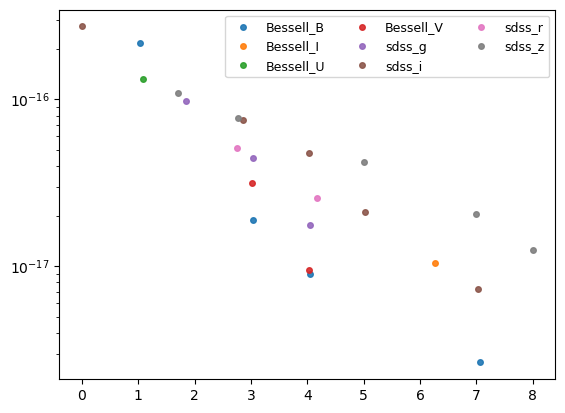

In [11]:
for ff in np.unique(SN.clipped_phot['band'])[:]:
    msk=SN.clipped_phot['band']==ff
    print (ff, min(SN.clipped_phot['MJD'][msk]))
    plt.plot(SN.clipped_phot['MJD'][msk]-min(SN.clipped_phot['MJD']),
             SN.clipped_phot['Flux'][msk], 'o', ms=4, alpha=0.9, label=ff)
plt.legend(ncol=3, fontsize=9, loc='upper right')
plt.yscale('log')

Bessell_I


ValueError: max() iterable argument is empty

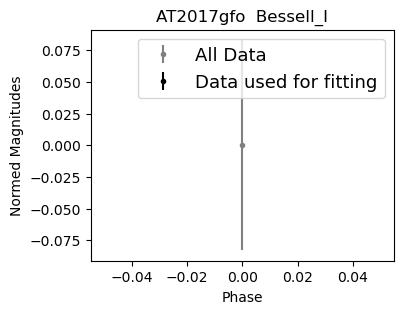

In [30]:
# If you didn't specify you want to extend a certain Templ / Filter in the dictionary dict_phase_tail no extension will be performed.
df = SN.create_extended_LC()
df.to_csv(OUTPUT_PATH+'/%s.dat'%snname, na_rep='nan',
              index=False, sep='\t')